In [1]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive/')

    %cd drive/MyDrive/bmw-data-drift-detection/notebooks

    !pip install hydra-core omegaconf pytorch_lightning 

In [2]:
import os,sys,inspect
import hydra
import omegaconf
import torch
from omegaconf import DictConfig

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

from models import VAE
from src import mvtec_loader as mloader

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint 
import torchvision as tv
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import pytorch_lightning
pytorch_lightning.__version__

'1.4.0'

In [4]:
cfg = omegaconf.OmegaConf.load('../config/config.yaml')

# IN VAE we create bigger encoder yet the only difference between AE and VAE config
cfg.arch.cnn_enc.output_size = 512

In [5]:
target='bottle'

transform  = tv.transforms.Compose([tv.transforms.ToPILImage(),
                                    #tv.transforms.Grayscale(num_output_channels=3),
                                    tv.transforms.Resize((cfg.arch.cnn_enc.input_height, cfg.arch.cnn_enc.input_width)),
                                    tv.transforms.ToTensor(), 
                                    #tv.transforms.Normalize((0.5,), (0.5,))
                                   ])

mvtec_loader = mloader.MVTecADDataset('../data/mvtec_anomaly_detection', 
                                      results_root=os.path.join('../', cfg.exp.results_path, '_' + cfg.exp.run_id),
                                      targets=[target], 
                                      create_or_load=True,
                                      reprod=True,
                                      idx_file='idx_' + cfg.exp.run_id, #+ '_split.pkl',
                                      targets_file='targets_' + cfg.exp.run_id, # + '.pkl',
                                      transforms=transform,
                                      batch_size=cfg.exp.batch_size,
                                      val_ratio=0.0,
                                      num_workers=cfg.data.num_workers)

targets to be used are:  bottle


# Training model

In [ ]:
model = VAE.VAE(cfg)

In [11]:
early_stop_callback = EarlyStopping(monitor= 'train_loss',
                                    min_delta=0.00, 
                                    patience=cfg.exp.early_stopping_patience, 
                                    verbose=False, 
                                    mode='min')
#checkpoint_callback = CustomModelCheckpoint(model=model, verbose=True, monitor='val_loss', mode='min', save_top_k=1)
lr_logging_callback = LearningRateMonitor(logging_interval='epoch')
checkpoint_callback = ModelCheckpoint(save_last=True, 
                                      save_top_k=1, 
                                      monitor="train_loss", 
                                      every_n_epochs=1)
trainer = Trainer(gpus=cfg.exp.gpus,
                  max_epochs=cfg.exp.max_epochs,
                  #auto_lr_find=self.args.optimizer.auto_lr_find,
                  accelerator='dp',
                  log_every_n_steps=5,
                  profiler='simple',
                  check_val_every_n_epoch=cfg.exp.check_val_every_n_epoch,
                  callbacks=[lr_logging_callback, early_stop_callback])

trainer.fit(model, datamodule=mvtec_loader)
trainer.test(model, datamodule=mvtec_loader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:287: LightningDeprecationWarning: Passing `Trainer(accelerator='dp')` has been deprecated in v1.5 and will be removed in v1.7. Use `Trainer(strategy='dp')` instead.
  f"Passing `Trainer(accelerator={self.distributed_backend!r})` has been deprecated"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Missing logger folder: /content/drive/MyDrive/bmw-data-drift-detection/notebooks/lightning_logs

  | Name    | Type        | Params
----------------------------------------
0 | encoder | CNN_Encoder | 13.5 

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Streaming output truncated to the last 5000 lines.
shape deconv
torch.Size([16, 3, 150, 150])
shape return
torch.Size([48, 22500])
tensor(393444.4375, device='cuda:0', grad_fn=<AddBackward0>)
shape deconv
torch.Size([16, 3, 150, 150])
shape return
torch.Size([48, 22500])
tensor(392255.6562, device='cuda:0', grad_fn=<AddBackward0>)
shape deconv
torch.Size([16, 3, 150, 150])
shape return
torch.Size([48, 22500])
tensor(392932.1250, device='cuda:0', grad_fn=<AddBackward0>)
shape deconv
torch.Size([16, 3, 150, 150])
shape return
torch.Size([48, 22500])
tensor(393493.9375, device='cuda:0', grad_fn=<AddBackward0>)
shape deconv
torch.Size([16, 3, 150, 150])
shape return
torch.Size([48, 22500])
tensor(393127.6250, device='cuda:0', grad_fn=<AddBackward0>)
shape deconv
torch.Size([16, 3, 150, 150])
shape return
torch.Size([48, 22500])
tensor(394322.4688, device='cuda:0', grad_fn=<AddBackward0>)
shape deconv
torch.Size([16, 3, 150, 150])
shape return
torch.Size([48, 22500])
tensor(394835.1875, dev

FIT Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  1.0995e+04     	|  100 %          	|
--------------------------------------------------------------------------------------------------------------------------------------
run_training_epoch                 	|  54.918         	|200            	|  1.0984e+04     	|  99.894         	|
run_training_batch                 	|  3.7716         	|2600           	|  9806.2         	|  89.186         	|
optimizer_step_with_closure_0      	|  3.5121         	|2600           	|  9131.4         	|  83.049         	|
training_step_and_backward         	|  3.5029         	|2600           	|  9107.6         	|  82.832         	|
model_forward                      

Testing: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


shape deconv
torch.Size([16, 3, 150, 150])
shape return
torch.Size([48, 22500])
tensor(406162.3438, device='cuda:0')
shape deconv
torch.Size([16, 3, 150, 150])
shape return
torch.Size([48, 22500])
tensor(400191.7500, device='cuda:0')
shape deconv
torch.Size([16, 3, 150, 150])
shape return
torch.Size([48, 22500])
tensor(402252.0938, device='cuda:0')
shape deconv
torch.Size([16, 3, 150, 150])
shape return
torch.Size([48, 22500])
tensor(397683.7188, device='cuda:0')
shape deconv
torch.Size([16, 3, 150, 150])
shape return
torch.Size([48, 22500])
tensor(398527.5312, device='cuda:0')
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 400963.5, 'test_loss_epoch': 400963.5}
--------------------------------------------------------------------------------


TEST Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  1.1019e+04     	|  100 %          	|
---------------------------------------------------------------------------------------------------------------------------------------
run_training_epoch                 	|  54.918         	|200            	|  1.0984e+04     	|  99.678         	|
run_training_batch                 	|  3.7716         	|2600           	|  9806.2         	|  88.994         	|
optimizer_step_with_closure_0      	|  3.5121         	|2600           	|  9131.4         	|  82.869         	|
training_step_and_backward         	|  3.5029         	|2600           	|  9107.6         	|  82.654         	|
model_forward                   

[{'test_loss': 400963.5, 'test_loss_epoch': 400963.5}]

In [12]:
trainer.save_checkpoint("model_vae.ckpt")

# Model experiments

In [6]:
from src import utils
import matplotlib.colors as mcolors
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [7]:
model = VAE.VAE.load_from_checkpoint('./model_vae.ckpt', args=cfg)

processing the batch: 0
processing the batch: 1
processing the batch: 2
processing the batch: 3
processing the batch: 4
Original images


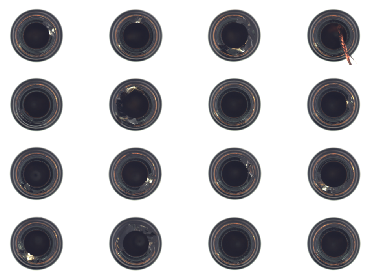

Transformed


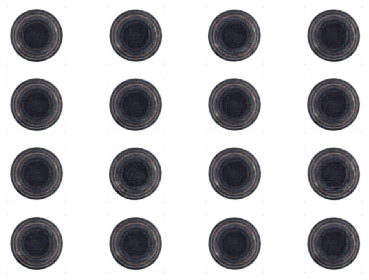

Reconstruction error for labels  {3: 0.0035562012, 2: 0.0030192756, 1: 0.0027818927, 0: 0.0016652753}


In [8]:
utils.reconstruction_vis(model, mvtec_loader.test_dataloader(), n_batches=10, batch_size=cfg.exp.batch_size)

targets to be used are:  transistor
processing the batch: 0
processing the batch: 1
processing the batch: 2
processing the batch: 3
processing the batch: 4
processing the batch: 5
Original images


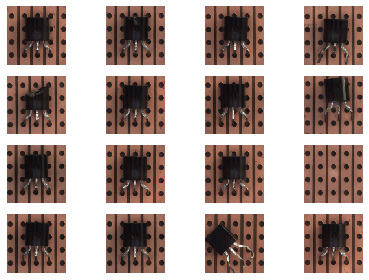

Transformed


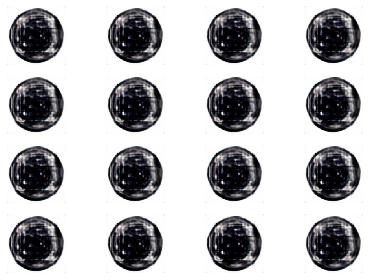

Reconstruction error for labels  {0: 0.16801618, 4: 0.16610469, 3: 0.16387261, 1: 0.16504128, 2: 0.17679557}


In [9]:
mvtec_loader_tr = mloader.MVTecADDataset(data_root='../data/mvtec_anomaly_detection', 
                                      results_root=os.path.join('../', cfg.exp.results_path, '_' + cfg.exp.run_id),
                                      targets=['transistor'], 
                                      create_or_load=True,
                                      reprod=True,
                                      idx_file='idx_' + cfg.exp.run_id, #+ '_split.pkl',
                                      targets_file='targets_' + cfg.exp.run_id, # + '.pkl',
                                      transforms=transform,
                                      batch_size=cfg.exp.batch_size,
                                      val_ratio=0.0,
                                      num_workers=cfg.data.num_workers)

utils.reconstruction_vis(model, mvtec_loader_tr.test_dataloader(), n_batches=10, batch_size=cfg.exp.batch_size)

targets to be used are:  hazelnut
processing the batch: 0
processing the batch: 1
processing the batch: 2
processing the batch: 3
processing the batch: 4
processing the batch: 5
Original images


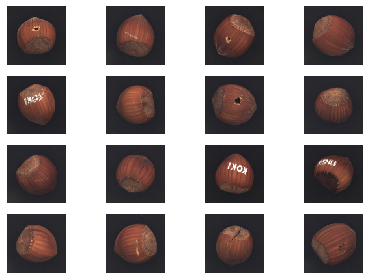

Transformed


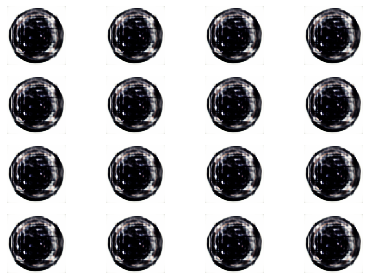

Reconstruction error for labels  {0: 0.275167, 2: 0.29335147, 4: 0.279972, 3: 0.27742505, 1: 0.27766588}


In [10]:
mvtec_loader_hz = mloader.MVTecADDataset(data_root='../data/mvtec_anomaly_detection', 
                                      results_root=os.path.join('../', cfg.exp.results_path, '_' + cfg.exp.run_id),
                                      targets=['hazelnut'], 
                                      create_or_load=True,
                                      reprod=True,
                                      idx_file='idx_' + cfg.exp.run_id, #+ '_split.pkl',
                                      targets_file='targets_' + cfg.exp.run_id, # + '.pkl',
                                      transforms=transform,
                                      batch_size=cfg.exp.batch_size,
                                      val_ratio=0.0,
                                      num_workers=cfg.data.num_workers)

utils.reconstruction_vis(model, mvtec_loader_hz.test_dataloader(), n_batches=10, batch_size=cfg.exp.batch_size)

### PCA and visualisation

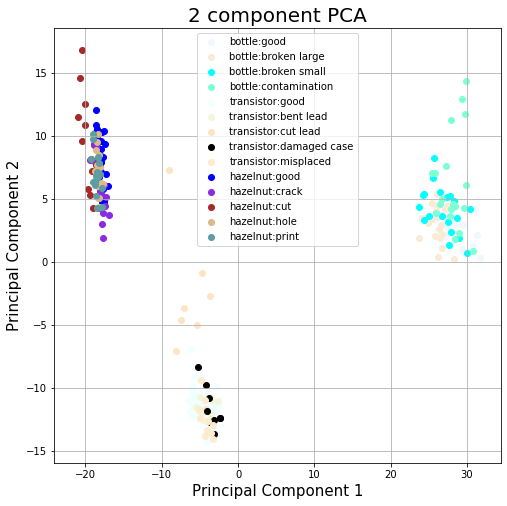

In [11]:
bottle_rerps, bottle_labels = utils.get_representations(model, mvtec_loader.test_dataloader())
transistor_reprs, transistor_labels = utils.get_representations(model, mvtec_loader_tr.test_dataloader())
hz_reprs, hz_labels = utils.get_representations(model, mvtec_loader_hz.test_dataloader())

# shift labels so that they won't be intersecting
bottle_labels = bottle_labels.flatten()
transistor_labels = transistor_labels.flatten() + (max(bottle_labels) + 1)
hz_labels += (max(transistor_labels) + 1)

y = list(bottle_labels)
y.extend(list(transistor_labels))
y.extend(list(hz_labels.flatten()))
y = np.array(y)

x = []

for reprs in [bottle_rerps, transistor_reprs, hz_reprs]:
    for batch in reprs:
        for obj in batch:
            x.append(obj.tolist())
            
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)

pc1 = principalComponents[:, 0]
pc2 = principalComponents[:, 1]

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 

colors = list(mcolors.CSS4_COLORS.values())
labels = {
    0 : "bottle:good",
    1 : "bottle:broken large",
    2 : "bottle:broken small",
    3 : "bottle:contamination",
    4 : "transistor:good",
    5 : "transistor:bent lead",
    6 : "transistor:cut lead",
    7 : "transistor:damaged case",
    8 : "transistor:misplaced",
    9 : "hazelnut:good",
    10: "hazelnut:crack",
    11: "hazelnut:cut",
    12: "hazelnut:hole",
    13: "hazelnut:print",

}

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

for k, v in labels.items():
    ax.scatter(pc1[y == k], pc2[y == k], c=colors[k], label=v)

#ax.scatter(pc1[y == 1], pc2[y == 1], c='g', label='transistor')

ax.legend()
ax.grid()